In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
!pip install -q yfinance

In [24]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# Download Tesla stock data from 2018 to 2022
ticker = "TSLA"
start_date = "2018-01-01"
end_date = "2022-12-31"

data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data["Close"].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
normalized_close_prices = scaler.fit_transform(close_prices)

# Create the input and target data
sequence_length = 180
input_data = []
target_data = []

for i in range(len(normalized_close_prices) - sequence_length):
    input_data.append(normalized_close_prices[i:i+sequence_length])
    target_data.append(normalized_close_prices[i+sequence_length])

input_data = torch.tensor(input_data).float()
target_data = torch.tensor(target_data).float()

# Create DataLoader
dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the MultiHeadSelfAttention module
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)

        self.Wo = nn.Linear(d_model, d_model)

    def forward(self, x):
        N, T, E = x.size()

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        q = q.view(N, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(N, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(N, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (E ** (1/2))
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_probs, v)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(N, T, E)
        output = self.Wo(attn_output)

        return output

# Define the TimeSeriesTransformerEncoder model
class TimeSeriesTransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads):
        super(TimeSeriesTransformerEncoder, self).__init__()

        self.self_attention = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output = self.self_attention(x)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

class TimeSeriesPredictor(nn.Module):
    def __init__(self, d_model, num_heads):
        super(TimeSeriesPredictor, self).__init__()
        self.embedding = nn.Linear(1, d_model)
        self.encoder = TimeSeriesTransformerEncoder(d_model, num_heads)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.fc(x[:, -1])
        return x

# Instantiate the TimeSeriesPredictor
d_model = 64
num_heads = 8
predictor = TimeSeriesPredictor(d_model, num_heads)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = predictor(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Forecasting
last_sequence = torch.tensor(normalized_close_prices[-sequence_length:]).float().unsqueeze(0)
predicted_normalized_price = predictor(last_sequence)
predicted_price = scaler.inverse_transform(predicted_normalized_price.detach().numpy())

print(f"Predicted close price for the next day: {predicted_price[0][0]:.2f}")

[*********************100%***********************]  1 of 1 completed
Epoch [10/100], Loss: 0.0003
Epoch [20/100], Loss: 0.0004
Epoch [30/100], Loss: 0.0010
Epoch [40/100], Loss: 0.0007
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0003
Predicted close price for the next day: 117.88


In [27]:
import numpy as np

# Function to forecast next `num_days` closing prices
def forecast(predictor, input_sequence, num_days):
    forecasted_prices = []

    for _ in range(num_days):
        predicted_normalized_price = predictor(input_sequence)
        forecasted_prices.append(predicted_normalized_price.item())
        next_input = torch.cat((input_sequence[:, 1:], predicted_normalized_price.unsqueeze(0).unsqueeze(1)), dim=1)
        input_sequence = next_input

    return np.array(forecasted_prices)

# Forecasting for the next six months (roughly 180 days)
num_days_to_forecast = 180
last_sequence = torch.tensor(normalized_close_prices[-sequence_length:]).float().unsqueeze(0)
forecasted_normalized_prices = forecast(predictor, last_sequence, num_days_to_forecast)

# Inverse transform the normalized prices to actual prices
forecasted_prices = scaler.inverse_transform(forecasted_normalized_prices.reshape(-1, 1))

print("Forecasted close prices for the next six months (180 days):")
for i, price in enumerate(forecasted_prices):
    print(f"Day {i + 1}: {price[0]:.2f}")

RuntimeError: Tensors must have same number of dimensions: got 3 and 4

In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

# Fetch the dataset and preprocess it
tesla_stock = yf.Ticker("TSLA")
data = tesla_stock.history(start="2018-01-01", end="2022-12-31")
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the close prices
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_close_prices = scaler.fit_transform(close_prices)

# Define the create_sequences function
def create_sequences(data, sequence_length):
    inputs, targets = [], []
    for i in range(len(data) - sequence_length):
        inputs.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(inputs), np.array(targets)

# Prepare the training and validation sets
sequence_length = 60
inputs, targets = create_sequences(normalized_close_prices, sequence_length)
train_size = int(len(inputs) * 0.8)
train_inputs, train_targets = torch.tensor(inputs[:train_size]).float(), torch.tensor(targets[:train_size]).float()
val_inputs, val_targets = torch.tensor(inputs[train_size:]).float(), torch.tensor(targets[train_size:]).float()

# DataLoader for the training set
train_data = torch.utils.data.TensorDataset(train_inputs, train_targets)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

# Define the TimeSeriesTransformerEncoder and other necessary classes here
# (The classes should be the same as in the previous responses)

# Instantiate the TimeSeriesPredictor
d_model = 64
num_heads = 8
predictor = TimeSeriesPredictor(d_model, num_heads)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = predictor(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Forecasting for the first three months of 2023 (roughly 90 days)
num_days_to_forecast = 90
last_sequence = torch.tensor(normalized_close_prices[-sequence_length:]).float()
forecasted_normalized_prices = forecast(predictor, last_sequence, num_days_to_forecast)

# Inverse transform the normalized prices to actual prices
forecasted_prices = scaler.inverse_transform(forecasted_normalized_prices.reshape(-1, 1))

# Fetch the true values for the first three months of 2023
data_2023 = tesla_stock.history(start="2023-01-01", end="2023-03-31")
true_values = data_2023['Close'].values

# Ensure that the true_values and forecasted_prices arrays have the same length
min_length = min(len(true_values), len(forecasted_prices))
true_values = true_values[:min_length]
forecasted_prices = forecasted_prices[:min_length]

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(true_values, forecasted_prices))
mae = mean_absolute_error(true_values, forecasted_prices)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Print the forecasted and true closing prices
print("\nForecasted and true closing prices for the first three months of 2023:")
for i, (forecasted, true) in enumerate(zip(forecasted_prices, true_values)):
    print(f"Day {i + 1}: {forecasted[0]:.2f} (forecasted), {true:.2f} (true)")



Epoch [10/100], Loss: 0.0003
Epoch [20/100], Loss: 0.0003
Epoch [30/100], Loss: 0.0002
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003
RMSE: 69.54
MAE: 60.81

Forecasted and true closing prices for the first three months of 2023:
Day 1: 124.28 (forecasted), 108.10 (true)
Day 2: 125.21 (forecasted), 113.64 (true)
Day 3: 126.00 (forecasted), 110.34 (true)
Day 4: 126.66 (forecasted), 113.06 (true)
Day 5: 127.19 (forecasted), 119.77 (true)
Day 6: 127.61 (forecasted), 118.85 (true)
Day 7: 127.94 (forecasted), 123.22 (true)
Day 8: 128.17 (forecasted), 123.56 (true)
Day 9: 128.31 (forecasted), 122.40 (true)
Day 10: 128.38 (forecasted), 131.49 (true)
Day 11: 128.39 (forecasted), 128.78 (true)
Day 12: 128.32 (forecasted), 127.17 (true)
Day 13: 128.19 (forecasted), 133.42 (true)
Day 14: 128.01 (forecasted), 143.75 (true)
Day 15: 127.78 (forec

In [31]:
def forecast(model, initial_sequence, num_days_to_forecast):
    model.eval()
    current_sequence = initial_sequence.unsqueeze(0)
    forecasted_prices = []

    with torch.no_grad():
        for _ in range(num_days_to_forecast):
            prediction = model(current_sequence)
            forecasted_prices.append(prediction[0, -1].item())

            current_sequence = torch.cat([current_sequence[:, 1:], prediction.unsqueeze(1)], dim=1)

    return np.array(forecasted_prices)

In [38]:
forecasted_prices

array([[124.28274765],
       [125.21420119],
       [126.0005529 ],
       [126.65502947],
       [127.18885279],
       [127.61256859],
       [127.93622441],
       [128.16732918],
       [128.31437644],
       [128.3846972 ],
       [128.38524288],
       [128.31961965],
       [128.19386554],
       [128.01229847],
       [127.78186986],
       [127.50744332],
       [127.19308769],
       [126.84380893],
       [126.46250147],
       [126.05232075],
       [125.61140436],
       [125.14227899],
       [124.64495651],
       [124.11946066],
       [123.56677601],
       [122.98867006],
       [122.38566478],
       [121.75943278],
       [121.11034177],
       [120.4397441 ],
       [119.74760417],
       [119.03650801],
       [118.30710804],
       [117.56073286],
       [116.79693171],
       [116.01526567],
       [115.21599571],
       [114.39921674],
       [113.56484572],
       [112.71539748],
       [111.85108557],
       [110.97219467],
       [110.07597862],
       [109

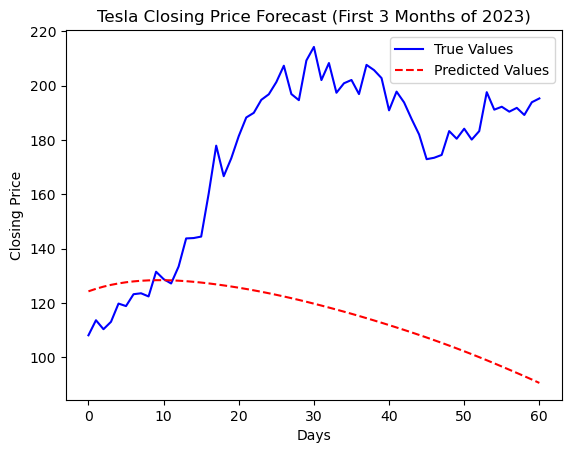

In [35]:
import matplotlib.pyplot as plt

# Plot the true and forecasted closing prices
plt.plot(true_values, label="True Values", color='blue')
plt.plot(forecasted_prices, label="Predicted Values", color='red', linestyle='--')
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.title("Tesla Closing Price Forecast (First 3 Months of 2023)")
plt.legend()
plt.show()


In [41]:
forecast_dates.info()

AttributeError: 'DatetimeIndex' object has no attribute 'info'

In [42]:
pd.date_range(start=data.index[-1] + pd.DateOffset(1), periods=num_days_to_forecast, freq='B')

DatetimeIndex(['2023-01-02 00:00:00-05:00', '2023-01-03 00:00:00-05:00',
               '2023-01-04 00:00:00-05:00', '2023-01-05 00:00:00-05:00',
               '2023-01-06 00:00:00-05:00', '2023-01-09 00:00:00-05:00',
               '2023-01-10 00:00:00-05:00', '2023-01-11 00:00:00-05:00',
               '2023-01-12 00:00:00-05:00', '2023-01-13 00:00:00-05:00',
               '2023-01-16 00:00:00-05:00', '2023-01-17 00:00:00-05:00',
               '2023-01-18 00:00:00-05:00', '2023-01-19 00:00:00-05:00',
               '2023-01-20 00:00:00-05:00', '2023-01-23 00:00:00-05:00',
               '2023-01-24 00:00:00-05:00', '2023-01-25 00:00:00-05:00',
               '2023-01-26 00:00:00-05:00', '2023-01-27 00:00:00-05:00',
               '2023-01-30 00:00:00-05:00', '2023-01-31 00:00:00-05:00',
               '2023-02-01 00:00:00-05:00', '2023-02-02 00:00:00-05:00',
               '2023-02-03 00:00:00-05:00', '2023-02-06 00:00:00-05:00',
               '2023-02-07 00:00:00-05:00', '2023-0

In [47]:
data.index[-1] 

Timestamp('2022-12-30 00:00:00-0500', tz='America/New_York')

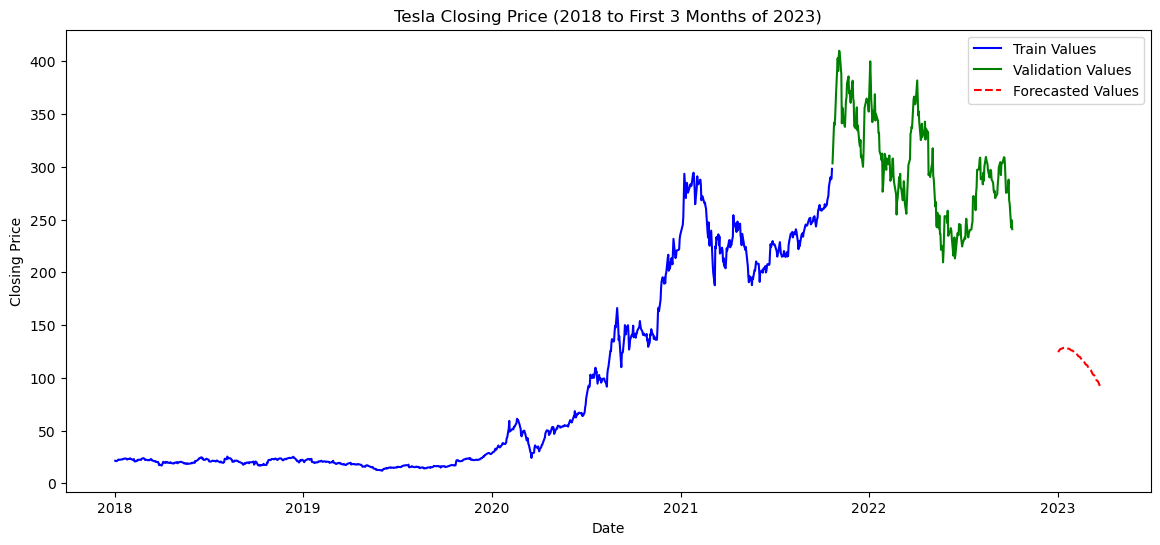

In [52]:
import matplotlib.pyplot as plt

# Create an array with dates for the forecasted period
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(1), periods=min_length, freq='B')

# Combine the real prices and forecasted prices into one DataFrame
real_prices = data["Close"]
forecasted_prices_df = pd.DataFrame(forecasted_prices, index=forecast_dates, columns=["Close"])
all_prices = pd.concat([real_prices, forecasted_prices_df])

# Plot the train, validation, and forecasted closing prices
plt.figure(figsize=(14, 6))

# Train values (2018 to 2022)
plt.plot(data.index[:train_size], data["Close"].iloc[:train_size], label="Train Values", color='blue')

# Validation values (remaining values in 2018 to 2022)
plt.plot(data.index[train_size:-sequence_length], data["Close"].iloc[train_size:-sequence_length], label="Validation Values", color='green')

# Forecasted values (first 3 months of 2023)
plt.plot(forecast_dates, forecasted_prices, label="Forecasted Values", color='red', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Tesla Closing Price (2018 to First 3 Months of 2023)")
plt.legend()
plt.show()
